In [18]:
from rosbag2_reader_py import Rosbag2Reader
import matplotlib.pyplot as plt

## Open ROS 2 Bag

**The file `rosbag2_reader_py.py` shall be in the same folder of the notebook.**

In [19]:
path = '/home/federico/lecture_ws/rosbag2_2024_12_07-12_32_45'

reader = Rosbag2Reader(path)
topics = reader.all_topics
topics

[INFO] [1733578431.207850648] [rosbag2_storage]: Opened database '/home/federico/lecture_ws/rosbag2_2024_12_07-12_32_45/rosbag2_2024_12_07-12_32_45_0.db3' for READ_ONLY.
[INFO] [1733578431.209788108] [rosbag2_storage]: Opened database '/home/federico/lecture_ws/rosbag2_2024_12_07-12_32_45/rosbag2_2024_12_07-12_32_45_0.db3' for READ_ONLY.


{'/ground_truth': 'nav_msgs/msg/Odometry',
 '/odom': 'nav_msgs/msg/Odometry',
 '/pf': 'nav_msgs/msg/Odometry'}

## Get total number of messages in the bag

In [20]:
tot_msgs = 0
for _ in reader:
    tot_msgs += 1

print(f"Total messages: {tot_msgs}")

[INFO] [1733578431.232102788] [rosbag2_storage]: Opened database '/home/federico/lecture_ws/rosbag2_2024_12_07-12_32_45/rosbag2_2024_12_07-12_32_45_0.db3' for READ_ONLY.


Total messages: 3036


## Select messages of specific topics

In [21]:
tot_msgs = 0
reader.set_filter(["/odom"])
for _ in reader:
    tot_msgs += 1

print("After the filter is applyed: ", reader.selected_topics)
print(f"Total messages: {tot_msgs}")

reader.reset_filter() # if you want to read all messages after you set a filter
print("After the filter is reset: ", reader.selected_topics)

[INFO] [1733578431.886121405] [rosbag2_storage]: Opened database '/home/federico/lecture_ws/rosbag2_2024_12_07-12_32_45/rosbag2_2024_12_07-12_32_45_0.db3' for READ_ONLY.
[INFO] [1733578431.887477067] [rosbag2_storage]: Opened database '/home/federico/lecture_ws/rosbag2_2024_12_07-12_32_45/rosbag2_2024_12_07-12_32_45_0.db3' for READ_ONLY.


After the filter is applyed:  {'/odom': 'nav_msgs/msg/Odometry'}
Total messages: 1641
After the filter is reset:  {'/ground_truth': 'nav_msgs/msg/Odometry', '/odom': 'nav_msgs/msg/Odometry', '/pf': 'nav_msgs/msg/Odometry'}


[INFO] [1733578432.196673412] [rosbag2_storage]: Opened database '/home/federico/lecture_ws/rosbag2_2024_12_07-12_32_45/rosbag2_2024_12_07-12_32_45_0.db3' for READ_ONLY.


## Access only data of a given type

In this example you can see  how to access an `Odometry` message checking for its type.

Please, notice the difference between **recording time** and time reported in the **stamp**. This is because the message was generated at a time that does not coincide with the time the message was received and recorded. This difference in a real robot may be really small, in the order of microseconds, but for a simulation, as in the reported case, the time could be extremely different. **You shall always use `header.stamp` whenever it is available.**

In [22]:
from rclpy.time import Time
from nav_msgs.msg import Odometry
for topic_name, msg, t in reader:
    print(f"Received message of type {type(msg).__name__} on topic {topic_name} recorded at time {t}")
    if type(msg) is Odometry:
        time = Time.from_msg(msg.header.stamp).nanoseconds
        print(f"Position (x, y) at time {time}: ({msg.pose.pose.position.x:.2f}, {msg.pose.pose.position.y:.2f})")
    break

Received message of type Odometry on topic /ground_truth recorded at time 1733571165393164413
Position (x, y) at time 83794000000: (-2.00, -0.50)


[INFO] [1733578432.210655848] [rosbag2_storage]: Opened database '/home/federico/lecture_ws/rosbag2_2024_12_07-12_32_45/rosbag2_2024_12_07-12_32_45_0.db3' for READ_ONLY.


## Interpolate data to compute metrics

In order to compute the metrics for `/odom` and `/ekf` topics, you have to compare the poses reported in these topic with the poses reported in topic `/ground_truth` in the same time instants. 

Since the data are generated from different nodes at different frequencies, the time of the various topics will be different. So, we need to interpolate ground truth data on the time scale of the topic we want to evaluate.

First of all, let us save relevant data from messages in some NumPy arrays. As you can see from the output, the number of points from the two topics is different.

In [23]:
import numpy as np
from scipy.interpolate import interp1d

time_gt = []
gt_data = []

time_odom = []
odom_data = []

time_pf = []
pf_data = []

for topic_name, msg, t in reader:
    if topic_name == "/ground_truth":
        time_gt.append(Time.from_msg(msg.header.stamp).nanoseconds)
        gt_data.append((msg.pose.pose.position.x, msg.pose.pose.position.y, msg.pose.pose.orientation.z))
    elif topic_name == "/odom":
        time_odom.append(Time.from_msg(msg.header.stamp).nanoseconds)
        odom_data.append((msg.pose.pose.position.x, msg.pose.pose.position.y, msg.pose.pose.orientation.z))
    elif topic_name == "/pf":
        time_pf.append(Time.from_msg(msg.header.stamp).nanoseconds)
        pf_data.append((msg.pose.pose.position.x, msg.pose.pose.position.y, msg.pose.pose.orientation.z))


time_gt = np.array(time_gt) - time_gt[0]
gt_data = np.array(gt_data)

time_odom = np.array(time_odom) - time_odom[0]
odom_data = np.array(odom_data)

time_pf = np.array(time_pf) - time_pf[0]
pf_data = np.array(pf_data)

print(f"Ground truth points: {len(gt_data)}")
print(f"Odometry points: {len(odom_data)}")
print(f"PF points: {len(pf_data)}")

print(f"Ground: {time_gt}")
print(f"Odometry: {time_odom}")
print(f"Ekf: {time_pf}")

[INFO] [1733578432.239599834] [rosbag2_storage]: Opened database '/home/federico/lecture_ws/rosbag2_2024_12_07-12_32_45/rosbag2_2024_12_07-12_32_45_0.db3' for READ_ONLY.


Ground truth points: 1116
Odometry points: 1641
PF points: 279
Ground: [          0    50000000   100000000 ... 55650000000 55700000000
 55750000000]
Odometry: [          0    34000000    68000000 ... 55692000000 55726000000
 55760000000]
Ekf: [          0   193904084   512546740   699240171   895985312  1199166399
  1396821517  1614043117  1907129212  2102638517  2293340886  2491507567
  2794885286  2998889619  3186325028  3396776668  3598692949  3810617860
  4144749695  4316785152  4525649691  4828842626  5118772186  5320387530
  5521141545  5714004526  6013576173  6202970760  6407416886  6609415191
  6803573847  7005183086  7209097135  7407729870  7610373713  7802969842
  8001928574  8222202865  8420052108  8629360767  8820480120  9022099959
  9220070996  9429218863  9628975070  9817685649 10018070937 10321721699
 10521187679 10720856323 10919809635 11119303580 11316785736 11520000099
 11733324053 11929192323 12125879295 12326841646 12527040218 12748062546
 12951597601 13128231317 1

Now, let us create an interpolating function using SciPy `interp1d`.

In [24]:
t_int = max(len(time_gt),len(time_odom),len(time_pf))
print(t_int)
t = time_odom

gt_interpol = interp1d(time_gt, gt_data, axis=0, fill_value="extrapolate")
gt_data_interp = gt_interpol(t)
print(f"Interpolated ground truth points: {len(gt_data_interp)}")

odom_interpol = interp1d(time_odom, odom_data, axis=0, fill_value="extrapolate")
odom_data_interp = odom_interpol(t)
print(f"Interpolated odom points: {len(odom_data_interp)}")

pf_interpol = interp1d(time_pf, pf_data, axis=0, fill_value="extrapolate")
pf_data_interp = pf_interpol(t)
print(f"Interpolated ekf points: {len(pf_data_interp)}")


1641
Interpolated ground truth points: 1641
Interpolated odom points: 1641
Interpolated ekf points: 1641


Compute Mean Absolute Error between odometry data and interpolated ground truth. You can find already implemented metrics functionson Portale della Didattica (Lecture_notebooks/Gaussian_filters.zip/utils.py)

MAE ground_truth vs odom :0.0006189049117571842
MAE ground_truth vs pf  :0.2854890193815975
RMSE ground_truth vs odom :0.0008227031215156318
RMSE ground_truth vs pf  :0.3825865588639298


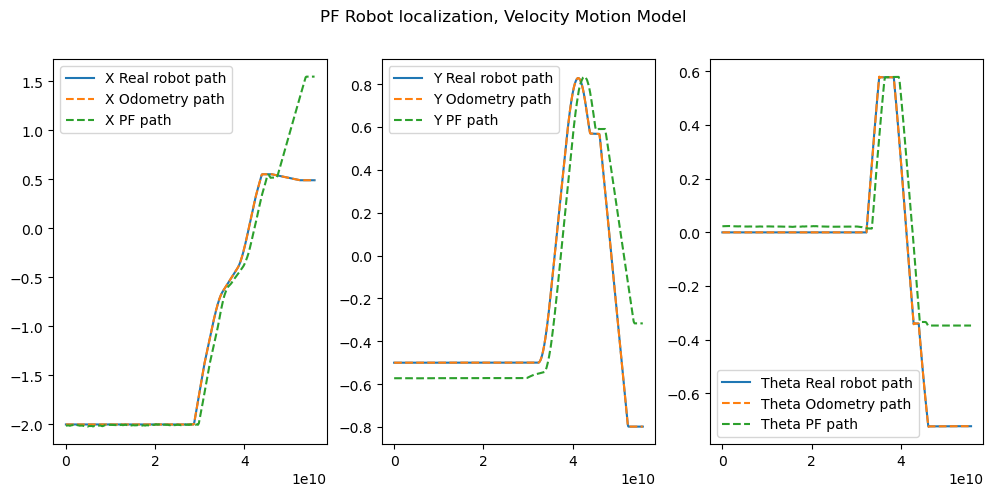

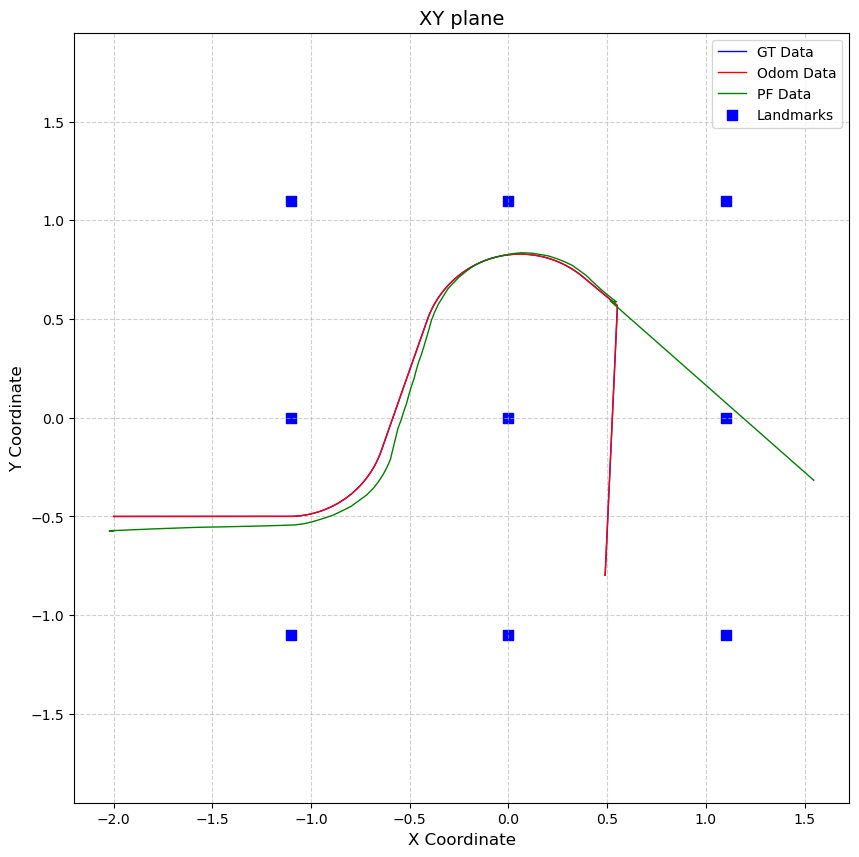

In [25]:
from math import pi
import numpy as np
import matplotlib.pyplot as plt
import yaml

print(f"MAE ground_truth vs odom :{np.mean(np.linalg.norm(odom_data_interp - gt_data_interp, axis=1), axis=0)}")
print(f"MAE ground_truth vs pf  :{np.mean(np.linalg.norm(pf_data_interp - gt_data_interp, axis=1), axis=0)}")

print(f"RMSE ground_truth vs odom :{np.sqrt(np.mean(np.sum((odom_data_interp[:, :2] - gt_data_interp[:, :2])**2, axis=1)))}")
print(f"RMSE ground_truth vs pf  :{np.sqrt(np.mean(np.sum((pf_data_interp[:, :2] - gt_data_interp[:, :2])**2, axis=1)))}")



# Draw plots
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("PF Robot localization, Velocity Motion Model")

track = np.array(gt_data_interp)
track_odom = np.array(odom_data_interp)
track_pf = np.array(pf_data_interp)

(track_legend,) = ax[0].plot(t, track[:, 0], label="X Real robot path")
(track_odom_legend,) = ax[0].plot(t, track_odom[:, 0], "--", label="X Odometry path")
(track_pf_legend,) = ax[0].plot(t, track_pf[:, 0], "--", label="X PF path")
ax[0].legend(handles=[track_legend, track_odom_legend,track_pf_legend])

(track_legend,) = ax[1].plot(t, track[:, 1], label="Y Real robot path")
(track_odom_legend,) = ax[1].plot(t, track_odom[:, 1], "--", label="Y Odometry path")
(track_pf_legend,) = ax[1].plot(t, track_pf[:, 1], "--", label="Y PF path")
ax[1].legend(handles=[track_legend, track_odom_legend,track_pf_legend])

(track_legend,) = ax[2].plot(t, track[:, 2], label="Theta Real robot path")
(track_odom_legend,) = ax[2].plot(t, track_odom[:, 2], "--", label="Theta Odometry path")
(track_pf_legend,) = ax[2].plot(t, track_pf[:, 2]/max(track_pf[:, 2])*max(track[:,2]), "--", label="Theta PF path")
ax[2].legend(handles=[track_legend, track_odom_legend,track_pf_legend])

track = np.array(gt_data)
track_odom = np.array(odom_data)
track_pf = np.array(pf_data)

#######################################################################################################################

yaml_file_path = '/home/federico/lecture_ws/src/turtlebot3_perception/turtlebot3_perception/config/landmarks.yaml'

# Carica i landmarks dal file YAML
with open(yaml_file_path, 'r') as file:
    data = yaml.safe_load(file)

# Estrai le coordinate x e y dei landmarks
landmarks_x = data['landmarks']['x']
landmarks_y = data['landmarks']['y']

# Coordinate di esempio per GT, odometria e filtro particellare
x = gt_data[:, 0]
y = gt_data[:, 1]
x_odom = odom_data[:, 0]
y_odom = odom_data[:, 1]
x_pf = pf_data[:, 0]
y_pf = pf_data[:, 1]

# Creiamo il grafico
plt.figure(figsize=(10, 10))
plt.plot(x, y, color='blue', linewidth=1, label='GT Data')
plt.plot(x_odom, y_odom, color='red', linewidth=1, label='Odom Data')
plt.plot(x_pf, y_pf, color='green', linewidth=1, label='PF Data')

# Aggiungiamo i landmarks al grafico
plt.scatter(landmarks_x, landmarks_y, color='blue', marker='s', s=60, label='Landmarks')

# Etichette e titolo
plt.xlabel('X Coordinate', fontsize=12)
plt.ylabel('Y Coordinate', fontsize=12)
plt.title('XY plane', fontsize=14)
plt.axis('equal')

# Aggiunta di griglia e legenda
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Mostra il grafico
plt.show()

